# Multas de tránsito en USA

Las infracciones de tráfico siguieron a la invención del automóvil: la primera multa de tráfico en los Estados Unidos supuestamente se le dio a un taxista de la ciudad de Nueva York el 20 de mayo de 1899 por ir a la vertiginosa velocidad de 12 millas por hora (aprox. 19.3 km/h). Desde entonces, se han emitido innumerables citaciones por infracciones de tránsito en todo el país, y los estados han cosechado miles de millones de dólares en ingresos de los infractores.

Las infracciones de tránsito generalmente se dividen en tipos de infracciones mayores y menores. El tipo más leve son las infracciones de estacionamiento, que no se cuentan en el historial de manejo, aunque una persona puede ser arrestada por infracciones no pagadas.

El tipo más común de infracción de tránsito es la infracción del límite de velocidad. Los límites de velocidad están definidos por estado.

El dataset fue obtenido de Kaggle: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils import LSTMModel, Optimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from scipy import signal

### Gráfica de la serie original - Lectura de datos

In [6]:
# Carga del dataset
inputfile="Traffic_Violations.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.rename(columns={'Date Of Stop': 'fecha_detencion'})
df = df.set_index(pd.DatetimeIndex(df['fecha_detencion']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("fecha_detencion").count()
# Informacion general
df.info()


Input file is: Traffic_Violations.csv
<class 'pandas.core.series.Series'>
DatetimeIndex: 1822 entries, 2012-01-01 to 2016-12-27
Series name: Count
Non-Null Count  Dtype
--------------  -----
1822 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


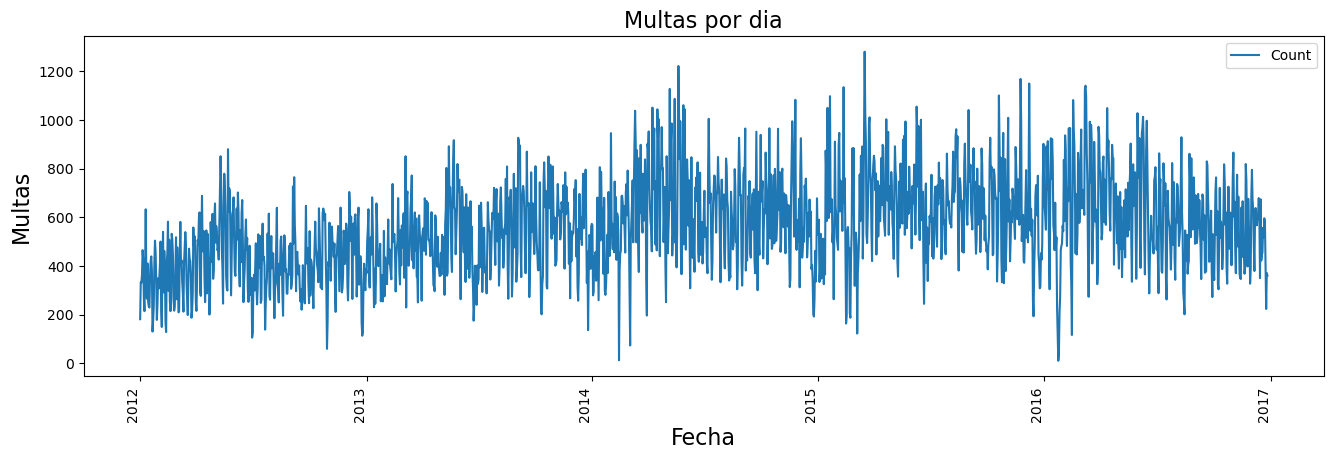

In [7]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Multas por dia", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

In [15]:
df.count()

1822

### Periodograma - Tomando muestras diarias durante los 5 años

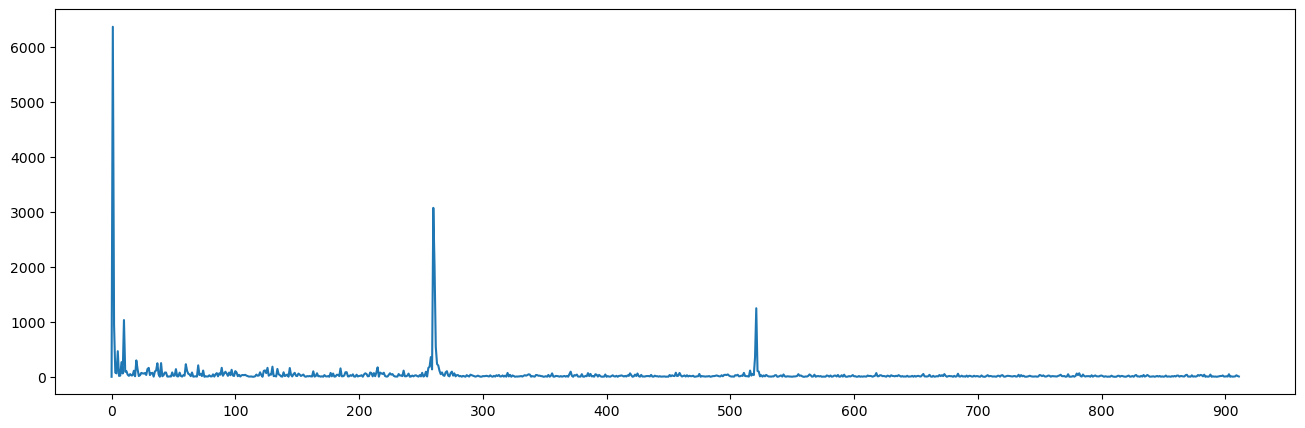

In [17]:


F, P_den = signal.periodogram(df.reset_index()[0:1822].Count,1822)
#F: muestras de frecuencias
#P_den: densidad espectral de potencia.
plt.plot(F, P_den)
plt.xticks(np.arange(0, len(F), step=100))
plt.show()

#### Observaciones en los primeros 100 dias

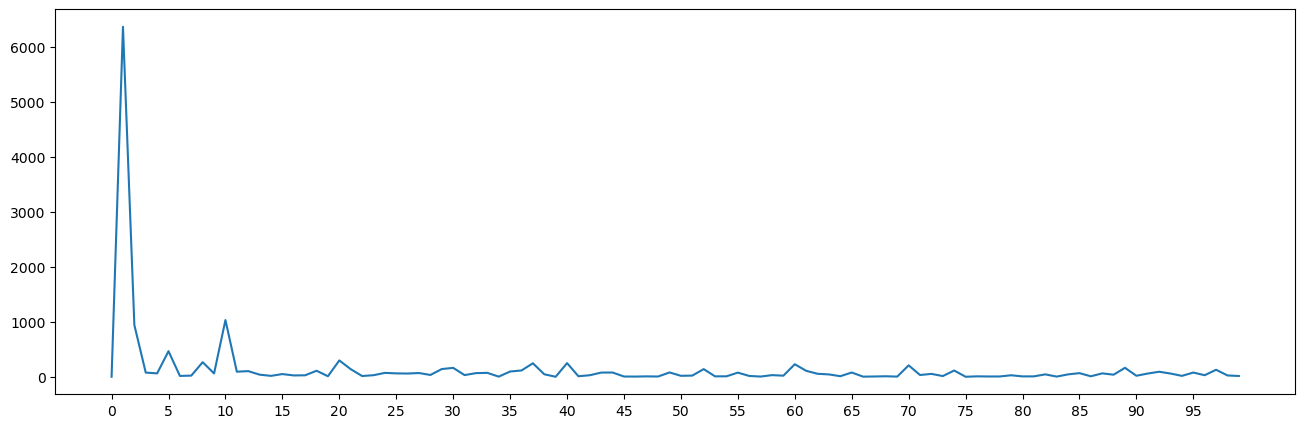

In [20]:
F, P_den = signal.periodogram(df.reset_index()[0:1822].Count,1822)
#F: muestras de frecuencias
#P_den: densidad espectral de potencia.
plt.plot(F[0:100], P_den[0:100])
plt.xticks(np.arange(0, 100, step=5))
plt.show()

#### Observaciones entre 250 y 300 dias

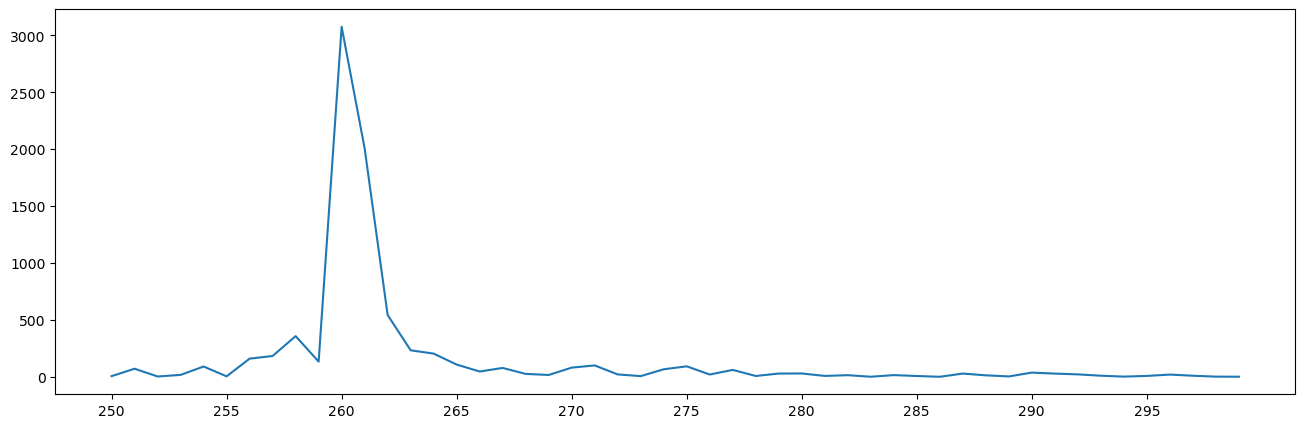

In [22]:
F, P_den = signal.periodogram(df.reset_index()[0:1822].Count,1822)
#F: muestras de frecuencias
#P_den: densidad espectral de potencia.
plt.plot(F[250:300], P_den[250:300])
plt.xticks(np.arange(250, 300, step=5))
plt.show()

#### Observaciones entre 500 y 600 dias

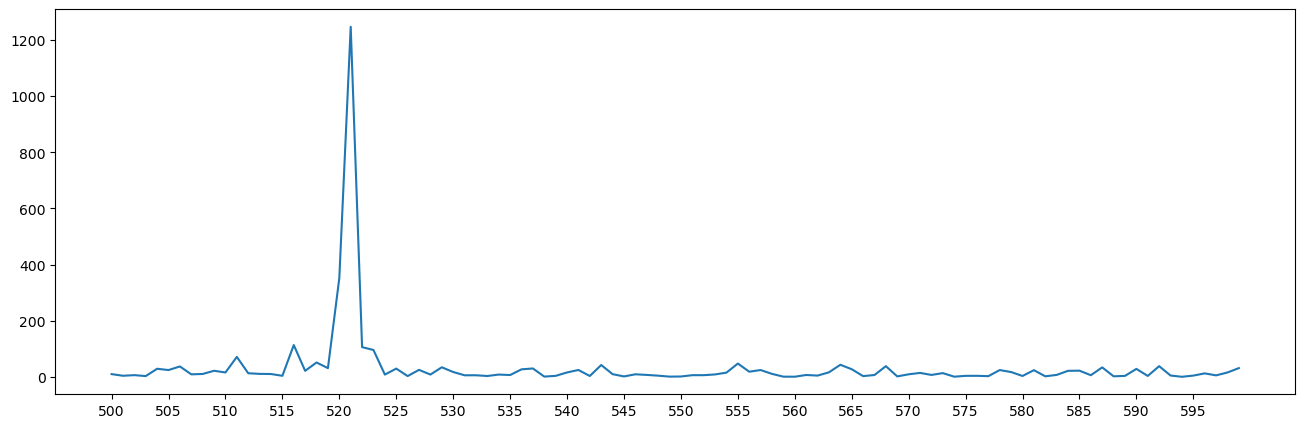

In [23]:
F, P_den = signal.periodogram(df.reset_index()[0:1822].Count,1822)
#F: muestras de frecuencias
#P_den: densidad espectral de potencia.
plt.plot(F[500:600], P_den[500:600])
plt.xticks(np.arange(500, 600, step=5))
plt.show()

### Conclusiones del periodograma a 5 años

Se encuentran frecuencias muy marcadas en 

- Frecuencia en 1,  => 1822/1 = 1822. Periodicidad de 5 años.

- Frecuencia en 10, => 1822/10 = 182,2. Periodicidad de 6 meses.

- Frecuencia en 260 => 1822/260 = 7. Periodicidad de 7 dias. - 1 semana

- Frecuencia en 520 => 1822/520 = 3.5. Periodicidad de aproximadamente 3 dias y 12hs.


### Periodograma - Tomando muestras diarias durante 1 año (2012)

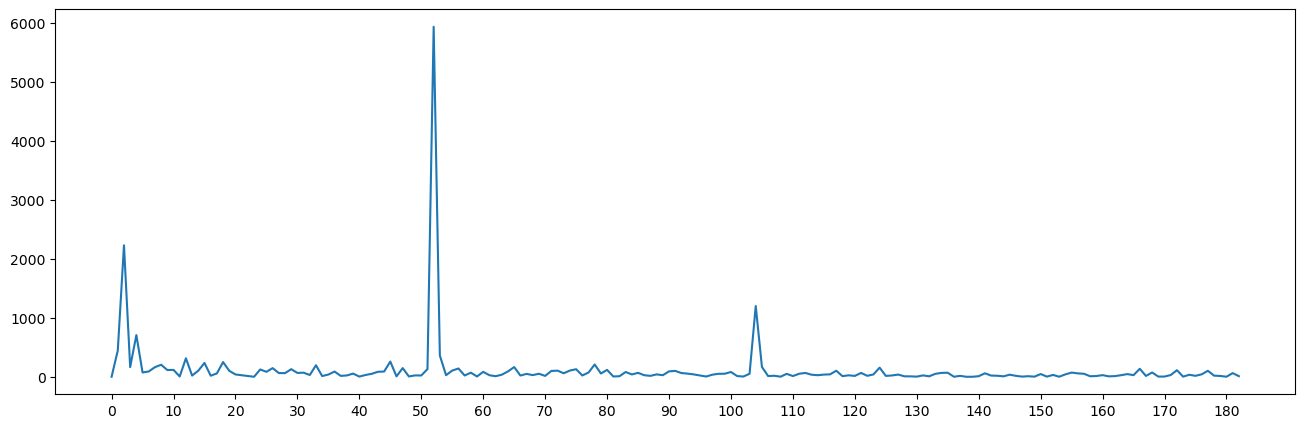

In [24]:
F, P_den = signal.periodogram(df.reset_index()[0:365].Count,365)
#F: muestras de frecuencias
#P_den: densidad espectral de potencia.
plt.plot(F, P_den)
plt.xticks(np.arange(0, len(F), step=10))
plt.show()

#### Observación de los primeros 30 dias

Se encuentran frecuencias muy marcadas en 

- Frecuencia en 2  => 365/2 = 180. Periodicidad de 6 meses.

- Frecuencia en 52, => 365/52 = 7. Periodicidad de 7 dias - 1 Semana.

- Frecuencia en 105 => 365/105 = 3.5. Periodicidad de 3 dias y 12 hs aproximadamente.

